# 2. Preparación de los datos seleccionados

In [1]:
#!pip install translate
#!pip install langdetect
#!pip install seaborn
#!pip install nltk

In [2]:
#pip install --upgrade langdetect

In [3]:
from translate import Translator   # traductor
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from langdetect import detect #, LangDetectError
#from langdetect.lang_detect_exception import LangDetectError
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import sys
import os

# Ruta del notebook actual
notebook_path = os.getcwd()

# Carpeta raíz del proyecto (sube un nivel: .. )
root_path = os.path.dirname(notebook_path)

# Agrega la carpeta raíz al PYTHONPATH
sys.path.append(root_path)

pdf_path = root_path+"\\pdfs"

In [5]:
pdf_path

'C:\\Users\\accar\\Notebooks\\ProyectoTesisMCD\\pdfs'

In [6]:
from app.utils.tratamiento_textos import extraer_pal_resumen

In [7]:
# import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#nltk.download('stopwords')
# nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('spanish')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\accar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
import sys;
sys.path.append("../");
from app.utils.funciones import mostrar_titulo, colores

## 1.1 Carga de datos de las carreras seleccionadas para el análisis de este proyecto

In [9]:
# Cargar datos. 
ruta_csv = "../datos/datos_carr_sel.csv"

df = pd.read_csv(ruta_csv, encoding='latin1', sep=";")

# mostrar las primeras filas
mostrar_titulo('Primeras filas del dataset')
df.head()

🔶 Primeras filas del dataset


,id,anio,titulo,descargas,vistas,google_scholar,tipo_tesis,carrera,facultad,url,pdf,resumen
0,59607,2016,La comunicación interna del Movimiento Juvenil...,261,104,https://scholar.google.com/scholar?as_q=&as_ep...,Tesis de Licenciatura,Licenciatura en Comunicaciones Sociales,Artes y Ciencias,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/596...,Formar parte del Movimiento Juvenil Salesiano ...
1,59611,2016,Blogs personales sobre moda de autores salteño...,244,124,https://scholar.google.com/scholar?as_q=&as_ep...,Tesis de Licenciatura,Licenciatura en Comunicaciones Sociales,Artes y Ciencias,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/596...,Las nuevas formas de comunicación posibilitan ...
2,59624,2016,Pinterest : Una herramienta de comunicación v...,167,66,https://scholar.google.com/scholar?as_q=&as_ep...,Tesis de Licenciatura,Licenciatura en Comunicaciones Sociales,Artes y Ciencias,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/596...,De la mano del vertiginoso avance tecnológico ...
3,60139,2016,"Identidad e imagen de la banda de rock, Gaucho...",626,131,https://scholar.google.com/scholar?as_q=&as_ep...,Tesis de Licenciatura,Licenciatura en Comunicaciones Sociales,Artes y Ciencias,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/601...,En la siguiente investigación se analizó cómo ...
4,60486,2016,El cine grotesco,235,133,https://scholar.google.com/scholar?as_q=&as_ep...,Tesis de Licenciatura,Licenciatura en Comunicaciones Sociales,Artes y Ciencias,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/604...,La presente investigación aborda el cuerpo hum...


In [10]:
#Cantidad de registros y campos
mostrar_titulo(f'Cantidad de registros: {df.shape[0]}')

🔶 Cantidad de registros: 417


## 1.2 Limpieza
Muchas técnicas modernas no realizan limpieza alguna. Dependiendo de lo que queramos hacer tal vez convenga deshacernos de algunos elementos. En el dataset de ejemplo los signos de puntuación no parecen tener gran relevancia, quizás tampoco la tengan los números (que aparentemente han sido removidos de antemano).

In [11]:
def reemplazar_simbolos(texto):  
  texto = texto.replace("_x000d_", "\n")
  texto = texto.replace("_x000D_", "\n")
  texto = texto.replace("_X000D_", "\n")
  texto = texto.lower().replace("universidad católica de salta", 'UCASAL')
  texto = texto.lower().replace(' dr.',' doctor')
  texto = texto.lower().replace(' hs.',' horas')
  caracteres=["\x93", "\x94","\x85","_x d_", "_x", "d_"]
  for caracter in caracteres:
    texto = texto.replace(caracter, " ")
  return texto

def verificar_idioma_espanol(texto):
    #separar en oraciones
    oraciones = nltk.sent_tokenize(texto)
    
    oraciones_espanol = []
    
    for oracion in oraciones:
        oracion = oracion.strip()
        if len(oracion) > 3:  # Ignorar oraciones muy cortas                              
            try:
                if detect(oracion) == 'es':    # Detectar idioma
                    oraciones_espanol.append(oracion)
            except Exception:
                pass #continue
  # Reconstruir el texto en español
    return "\n".join(oraciones_espanol)

def limpiar_texto(texto):
   # mantener puntuación y estructura
   texto = re.sub(r'[^\w\sáéíóúüñÁÉÍÓÚÜÑ.,!?;:]', ' ', texto)

   # eliminar saltos de lineas y espacios vacios
   texto = re.sub(r'\\n', ' ', texto)
   texto = re.sub(r'\s+', ' ', texto)

   # Convertir a minúsculas
   texto = texto.lower().strip()

   #eliminar números
   texto = re.sub(r'\d+(.\d+)?',' ', texto)

   return texto

#funciones para tokenizar 
def eliminar_stopwords(texto):
    return ' '.join([word for word in texto.split(' ') if word not in stopwords])

def eliminar_simbolos(texto):
   # mantener solo texto y espacios
   return re.sub(r'[^\w\sáéíóúüñÁÉÍÓÚÜÑ]', ' ', texto)
    
def eliminar_palabras_cortas(texto):
    if pd.isna(texto) or not isinstance(texto, str):
        return texto
    palabras = texto.split()
    palabras_filtradas = [palabra for palabra in palabras if len(palabra) > 1]
    return ' '.join(palabras_filtradas)

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
def lematizar(texto):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(texto, language='spanish')
    lemas=[]
    for word in tokens:
        # Lematizar como sustantivo por defecto
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)
    return ' '.join(lemas)
    
def lematizar(texto):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(texto, language='spanish')
    lemas=[]
    i=0
    for word in tokens:
        # Lematizar como sustantivo por defecto
        lema = lemmatizer.lemmatize(word)
        lemas.append(lema)
        if i<10:
            print(word,' '+lema)
        i+=1
    return ' '.join(lemas)


In [12]:
def extraer_pal_resumen1(df, pdf_path):

    for i in range(len(df)):
        reg=df.loc[i]
        tokens = word_tokenize(reg['resumen'])  #separa el texto en tokens
        cant_palabras = len([w for w in tokens if w.isalnum()])   #cuenta la cantidade palabras (sin símbolos)
        
        if cant_palabras<100:
            print(str(cant_palabras)+" "+str(reg['id']))
            #extraer un resumen de pdf y reemplazar
            filename = str(reg['pdf'])
            name = filename.split("/")[-1]
            pdf_file_path = os.path.join(pdf_path, str(filename))
            
            if pdf_file_path.lower().endswith('.pdf'):
                print(f"Resumiendo {name}...")
                summary_text = name   #####    esto VA: summarize_pdf_with_ollama(pdf_file_path)
                df.iloc[i]['resumen'] = summary_text                               
    return df
    
def contar_palabras(texto):
    tokens = word_tokenize(texto)  #separa el texto en tokens
    cant_palabras = len([w for w in tokens if w.isalnum()]) 
    return cant_palabras

In [13]:
df = df.fillna('')
df['resumen_orig']=df['resumen'] # se guarda para resguardo y control, solo texto en español

df['resumen'] = df['resumen'].apply(reemplazar_simbolos)
df['resumen'] = df['resumen'].apply(verificar_idioma_espanol)

In [14]:
df['palabras'] = df['resumen'].apply(contar_palabras)

In [15]:
# # si resumen tiene menos de 100 palabras, extraer un resumen de PDF
# df= extraer_pal_resumen1(df, pdf_path)
# df_nuevo

In [16]:

df['texto_limpio'] = df['titulo']+ '. ' +df['resumen']
df['texto_limpio'] = df['texto_limpio'].apply(limpiar_texto)


In [20]:

#df['texto_limpio'] = df['titulo']+ '. ' +df['resumen']

# # se limpian los campos textuales (resumen y titulo)
# df['texto_limpio'] = df['texto_limpio'].apply(reemplazar_texto)
# #df['texto_limpio'] = df['texto_limpio'].apply(verificar_idioma_espanol)
# df['texto_limpio'] = df['texto_limpio'].apply(limpiar_texto)

# se agrega otro campo para realizar pruebas en el modelado y para mostrar estadísticas en este notebook
df['texto_tok'] =  df['texto_limpio'].apply(eliminar_simbolos)
df['texto_tok'] = df['texto_tok'].apply(eliminar_stopwords)
df['texto_tok'] = df['texto_tok'].apply(eliminar_palabras_cortas)

In [21]:
#seleccionar campos titulo_limpio, resumen_limpio, facultad, carrera, descargas, vistas, id, anio
df_final=df[['id','anio','titulo', 'resumen','texto_limpio','texto_tok','facultad','carrera','descargas','vistas','url','pdf','resumen_orig','palabras']]

df_final.head()

,id,anio,titulo,resumen,texto_limpio,texto_tok,facultad,carrera,descargas,vistas,url,pdf,resumen_orig,palabras
0,59607,2016,La comunicación interna del Movimiento Juvenil...,formar parte del movimiento juvenil salesiano ...,la comunicación interna del movimiento juvenil...,comunicación interna movimiento juvenil salesi...,Artes y Ciencias,Licenciatura en Comunicaciones Sociales,261,104,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/596...,Formar parte del Movimiento Juvenil Salesiano ...,201
1,59611,2016,Blogs personales sobre moda de autores salteño...,las nuevas formas de comunicación posibilitan ...,blogs personales sobre moda de autores salteño...,blogs personales moda autores salteños estrate...,Artes y Ciencias,Licenciatura en Comunicaciones Sociales,244,124,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/596...,Las nuevas formas de comunicación posibilitan ...,279
2,59624,2016,Pinterest : Una herramienta de comunicación v...,de la mano del vertiginoso avance tecnológico ...,pinterest : una herramienta de comunicación vi...,pinterest herramienta comunicación visual iden...,Artes y Ciencias,Licenciatura en Comunicaciones Sociales,167,66,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/596...,De la mano del vertiginoso avance tecnológico ...,240
3,60139,2016,"Identidad e imagen de la banda de rock, Gaucho...",en la siguiente investigación se analizó cómo ...,"identidad e imagen de la banda de rock, gaucho...",identidad imagen banda rock gauchos acero sigu...,Artes y Ciencias,Licenciatura en Comunicaciones Sociales,626,131,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/601...,En la siguiente investigación se analizó cómo ...,166
4,60486,2016,El cine grotesco,la presente investigación aborda el cuerpo hum...,el cine grotesco. la presente investigación ab...,cine grotesco presente investigación aborda cu...,Artes y Ciencias,Licenciatura en Comunicaciones Sociales,235,133,https://bibliotecas.ucasal.edu.ar/opac_css/ind...,https://bibliotecas.ucasal.edu.ar/opac_css/604...,La presente investigación aborda el cuerpo hum...,105


## 2.3 Análisis exploratorio
Se presentan algunos gráficos para analizar las carreras seleccionadas para el proyecto

🔶 Distribución de TFG en carreras seleccionadas


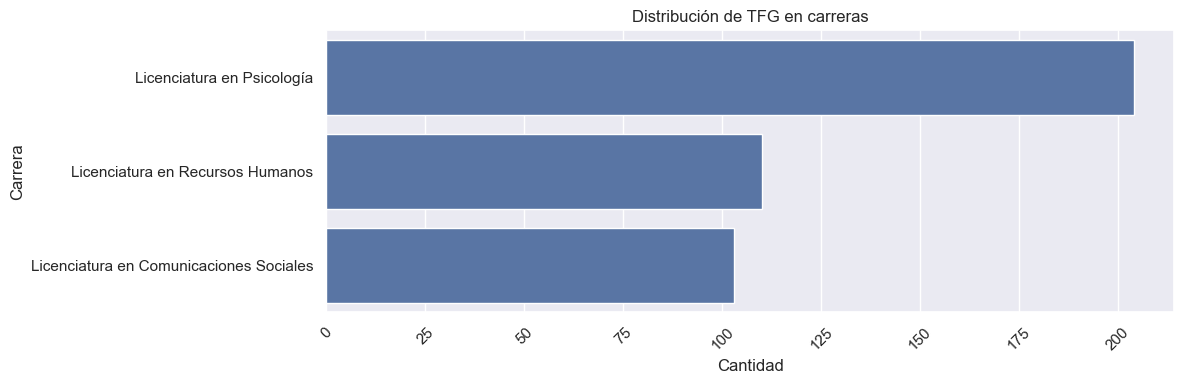

In [22]:
mostrar_titulo("Distribución de TFG en carreras seleccionadas")
# Crear un gráfico de barras
plt.figure(figsize=(12, 4))
df_ranking = df["carrera"].value_counts().reset_index()
df_ranking.columns = ["carrera", "cantidad"]

sns.barplot(df_ranking, x="cantidad", y="carrera", legend=False)
plt.title('Distribución de TFG en carreras')
plt.xlabel('Cantidad')
plt.ylabel('Carrera')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [23]:
# from collections import Counter
# # Unir todos los textos
# texto_completo = " ".join(df['texto_tok'].tolist())
# palabras = texto_completo.split()

# # Contar frecuencia
# frecuencia_palabras = Counter(palabras)
# top_palabras = frecuencia_palabras.most_common(20)

# print("Top 20 palabras más frecuentes:")
# for i, (palabra, freq) in enumerate(top_palabras, 1):
#     print(f"{i:2d}. {palabra:<15} : {freq:>3} ocurrencias")

In [24]:
carreras = df['carrera'].unique()
carreras

array(['Licenciatura en Comunicaciones Sociales',
       'Licenciatura en Recursos Humanos', 'Licenciatura en Psicología'],
      dtype=object)

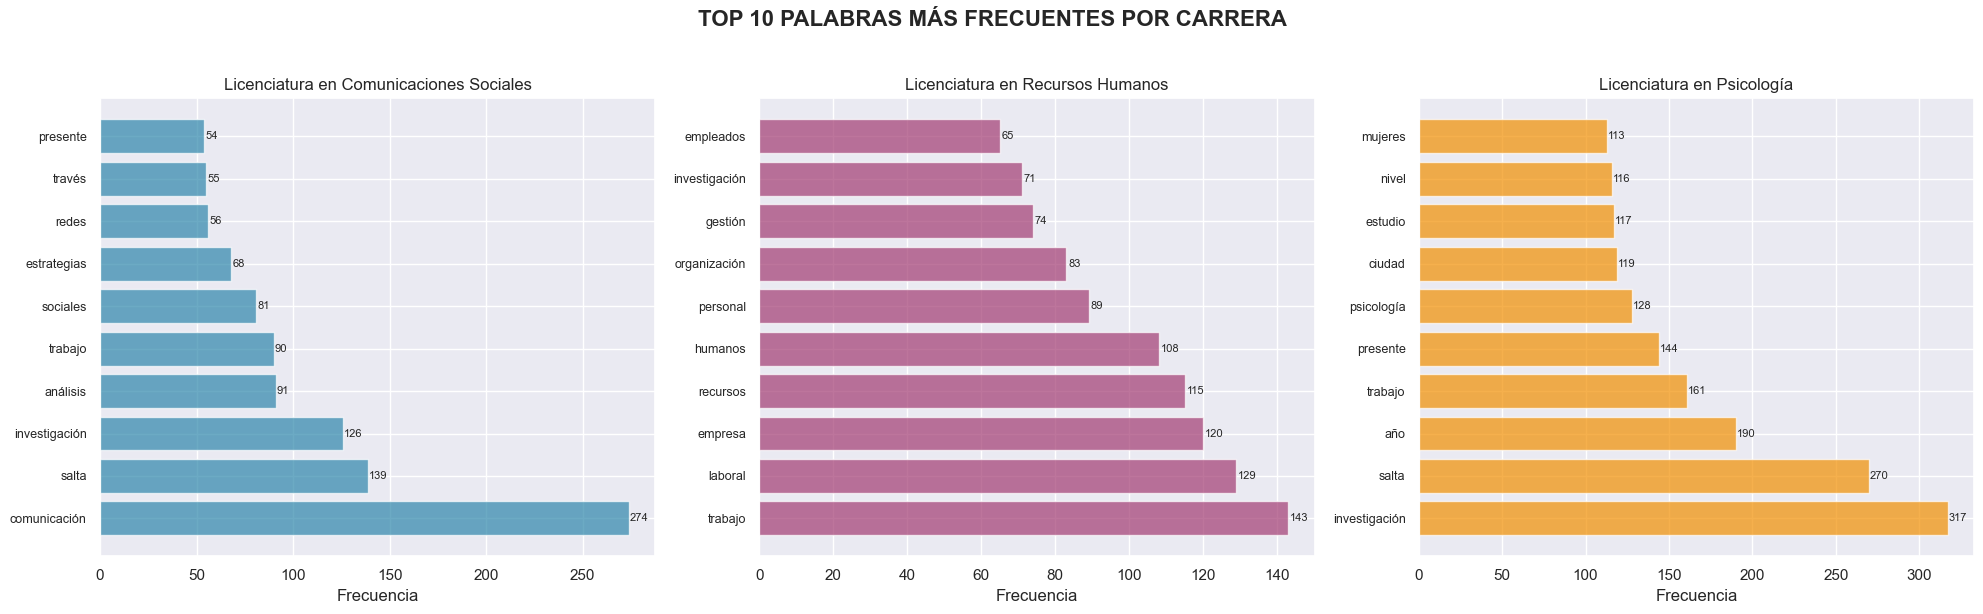


RESUMEN - TOP 5 PALABRAS POR CARRERA:
--------------------------------------------------------------------------------

LICENCIATURA EN COMUNICACIONES SOCIALES  Frecuencia  
-------------------------------------------------------
  1. comunicación                   274
  2. salta                          139
  3. investigación                  126
  4. análisis                        91
  5. trabajo                         90

LICENCIATURA EN RECURSOS HUMANOS         Frecuencia  
-------------------------------------------------------
  1. trabajo                        143
  2. laboral                        129
  3. empresa                        120
  4. recursos                       115
  5. humanos                        108

LICENCIATURA EN PSICOLOGÍA               Frecuencia  
-------------------------------------------------------
  1. investigación                  317
  2. salta                          270
  3. año                            190
  4. trabajo               

In [36]:
# Calcular frecuencias por carrera
frecuencias_carreras = {}
top_palabras_carreras = {}

for carrera in carreras:
    datos_carreras = df[df['carrera']==carrera]
    #texto_carrera = " ".join(datos_carreras[carrera]['texto_tok'].tolist())
    texto_carrera = " ".join(datos_carreras['texto_tok'].tolist())
    palabras = texto_carrera.split()
    frecuencias_carreras[carrera] = Counter(palabras)
    top_palabras_carreras[carrera] = frecuencias_carreras[carrera].most_common(10)

top_palabras_carreras  
# Mostrar tablas comparativas
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
#colores = ['#2E86AB', '#A23B72', '#F18F01']

for i, carrera in enumerate(carreras):
    datos_carreras = df[df['carrera']==carrera]
    palabras, frecuencias = zip(*top_palabras_carreras[carrera])
    
    axes[i].barh(range(len(palabras)), frecuencias, color=colores[i], alpha=0.7)
    axes[i].set_yticks(range(len(palabras)))
    axes[i].set_yticklabels(palabras, fontsize=9)
    #axes[i].set_title(f'{carrera}\n({len(datos_carreras[carrera])} documentos)',  fontweight='bold', fontsize=12)
    axes[i].set_title(carrera)
    axes[i].set_xlabel('Frecuencia')
    
    # Añadir valores en las barras
    for j, v in enumerate(frecuencias):
        axes[i].text(v + 0.5, j, str(v), va='center', fontsize=8)

plt.suptitle('TOP 10 PALABRAS MÁS FRECUENTES POR CARRERA', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tabla resumen de frecuencias
print("\nRESUMEN - TOP 5 PALABRAS POR CARRERA:")
print("-" * 80)
for i, carrera in enumerate(carreras):
    print(f"\n{carrera.upper():<40} {'Frecuencia':<12}")
    print("-" * 55)
    for j, (palabra, freq) in enumerate(top_palabras_carreras[carrera][:5], 1):
        print(f"  {j}. {palabra:<25} {freq:>8}")

🔶 Nubes de palabras


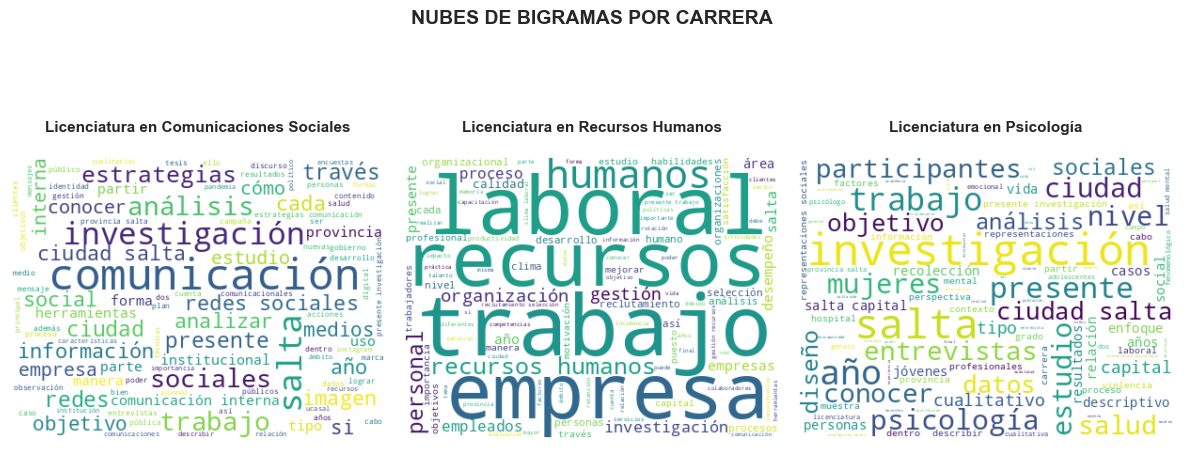

In [37]:
# def nubes_ngrams_comparativas(datos_carreras, ngram_range=(2,2), max_words=30):
#     """
#     Crea nubes de n-grams comparativas para múltiples carreras
#     """
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

mostrar_titulo('Nubes de palabras')
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
ngram_range=(1,2)
max_words=100

#for i, (carrera, datos) in enumerate(datos_carreras.items()):
for i, carrera in enumerate(carreras):
    datos_carreras = df[df['carrera']==carrera]
    texto_carrera = " ".join(datos_carreras['texto_tok'].tolist())
    
    textos = datos_carreras['texto_tok'].tolist()
    
    # Vectorizer para n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_words)
    X = vectorizer.fit_transform(textos)
    
    # Obtener n-grams y frecuencias
    ngrams = vectorizer.get_feature_names_out()
    frecuencias = np.asarray(X.sum(axis=0)).flatten()
    ngram_freq_dict = dict(zip(ngrams, frecuencias))
    
    # Crear nube
    wordcloud = WordCloud(
        width=400, 
        height=300, 
        background_color='white',
      #  colormap= colores, #['#2E86AB', '#A23B72', '#F18F01'][i],
        max_words=max_words
    ).generate_from_frequencies(ngram_freq_dict)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{carrera}\n', fontweight='bold', fontsize=11)
    axes[i].axis('off')

#tipo_ngram = "Bigrams" if ngram_range == (2,2) else f"{ngram_range[0]}-{ngram_range[1]} grams"
plt.suptitle(f'NUBES DE BIGRAMAS POR CARRERA', fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# # Usar con las 3 carreras
# print("NUBES COMPARATIVAS DE BIGRAMS")
# nubes_ngrams_comparativas(datos_carreras, ngram_range=(2,2), max_words=25)

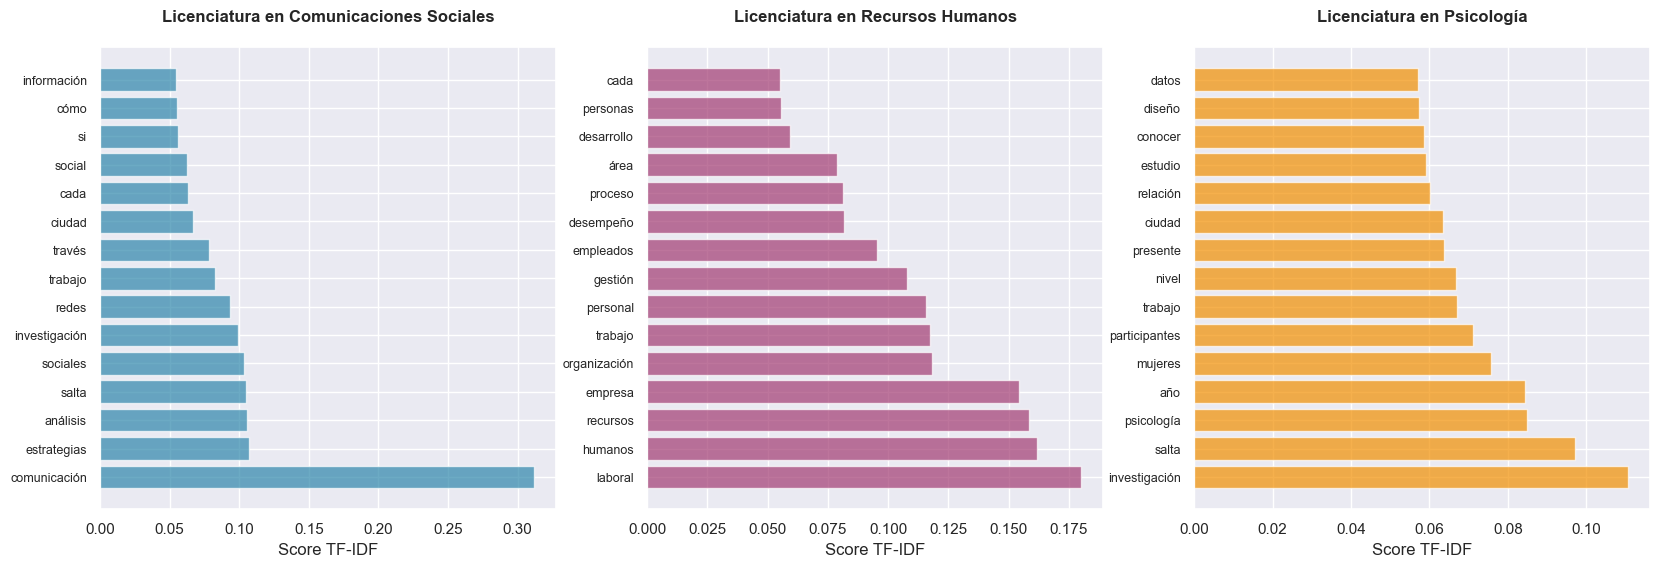

In [28]:
# Configurar TF-IDF para todas las carreras
vectorizer_global = TfidfVectorizer(max_features=100, min_df=2, max_df=0.9)
textos_todos = []
carrera_labels = []

for carrera in carreras:
    datos_carreras = df[df['carrera']==carrera]
    textos_carrera = datos_carreras['texto_tok'].tolist()
    textos_todos.extend(textos_carrera)
    carrera_labels.extend([carrera] * len(textos_carrera))

# Ajustar TF-IDF global
tfidf_global = vectorizer_global.fit_transform(textos_todos)
feature_names = vectorizer_global.get_feature_names_out()

# Calcular TF-IDF promedio por carrera
tfidf_por_carrera = {}

for carrera in carreras:
    indices_carrera = [i for i, label in enumerate(carrera_labels) if label == carrera]
    tfidf_carrera = tfidf_global[indices_carrera]
    scores_promedio = np.asarray(tfidf_carrera.mean(axis=0)).flatten()
    
    tfidf_por_carrera[carrera] = pd.DataFrame({
        'termino': feature_names,
        'tfidf_promedio': scores_promedio
    }).sort_values('tfidf_promedio', ascending=False).head(15)

# Gráfico comparativo TF-IDF
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, carrera in enumerate(carreras):
    datos_tfidf = tfidf_por_carrera[carrera].sort_values(by='tfidf_promedio',ascending=False).head(15)
    
    axes[i].barh(range(len(datos_tfidf)), datos_tfidf['tfidf_promedio'], color=colores[i], alpha=0.7)
    axes[i].set_yticks(range(len(datos_tfidf)))
    axes[i].set_yticklabels(datos_tfidf['termino'], fontsize=9)
    axes[i].set_title(f'{carrera}\n', fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Score TF-IDF')

    # Añadir valores
#     for j, v in enumerate(datos_tfidf['tfidf_promedio']):
#         axes[i].text(v + 0.001, j, f'{v:.3f}', va='center', fontsize=8)

# plt.suptitle('TOP 10 TÉRMINOS POR TF-IDF (Términos Especializados)', 
#              fontsize=16, fontweight='bold', y=1.02)
# plt.tight_layout()
# plt.show()

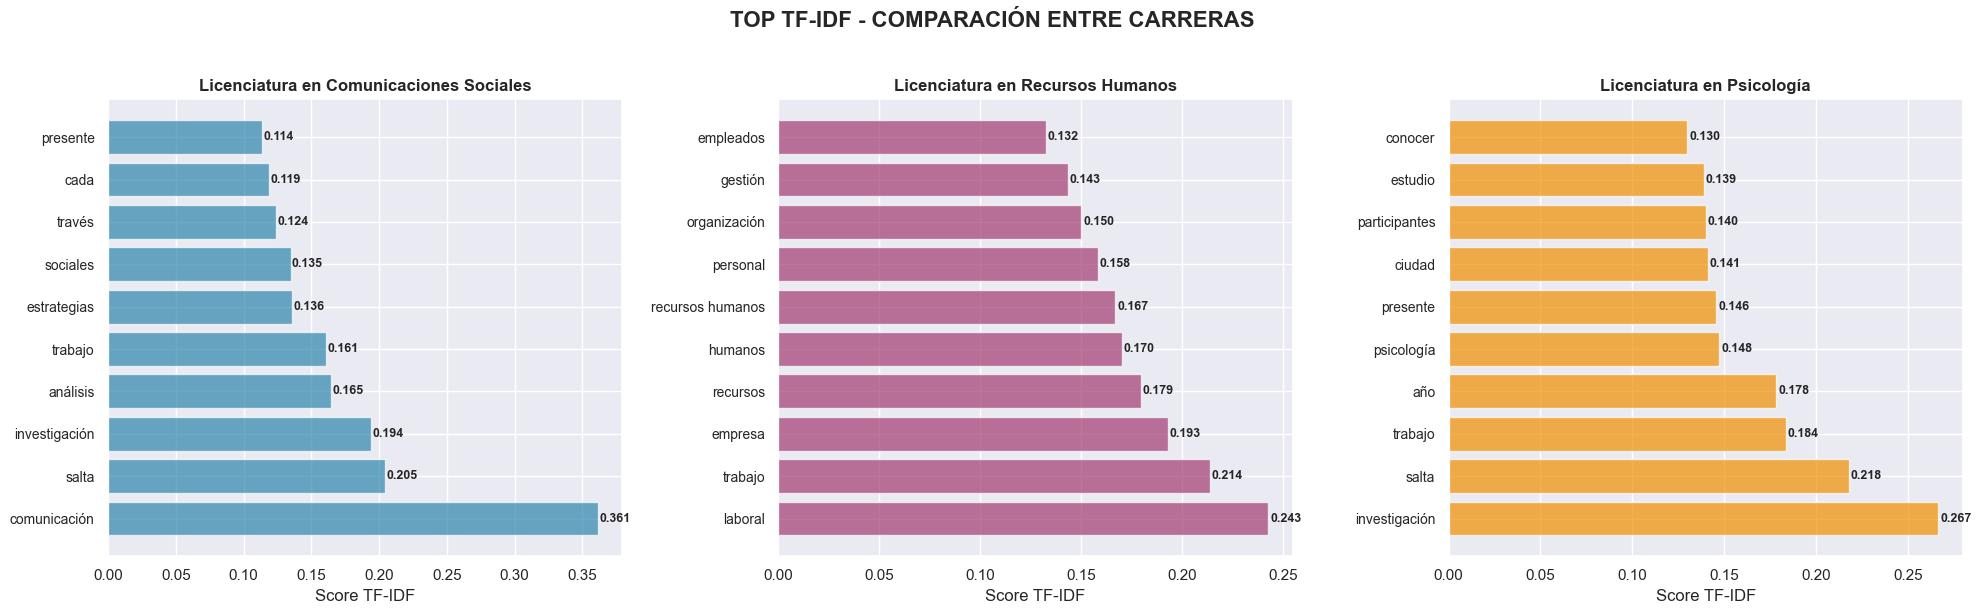


📊 TABLA RESUMEN - TOP 5 BIGRAMAS POR CARRERA:

🔹 LICENCIATURA EN COMUNICACIONES SOCIALES:
--------------------------------------------------
   1. comunicación                   0.3615
   2. salta                          0.2046
   3. investigación                  0.1944
   4. análisis                       0.1646
   5. trabajo                        0.1611

🔹 LICENCIATURA EN RECURSOS HUMANOS:
--------------------------------------------------
   1. laboral                        0.2425
   2. trabajo                        0.2135
   3. empresa                        0.1928
   4. recursos                       0.1794
   5. humanos                        0.1701

🔹 LICENCIATURA EN PSICOLOGÍA:
--------------------------------------------------
   1. investigación                  0.2667
   2. salta                          0.2181
   3. trabajo                        0.1838
   4. año                            0.1784
   5. psicología                     0.1475


In [29]:
# =============================================================================
# GRÁFICOS TF-IDF CON BIGRAMAS - 3 CARRERAS EN LÍNEA HORIZONTAL
# =============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer

# Configurar TF-IDF para bigramas
vectorizer_bigram = TfidfVectorizer(
    ngram_range=(1, 2),  # 1-grama y 2-gramas
    max_features=15,     # Top 15 bigramas por carrera
    min_df=2,
    max_df=0.8
)

# Calcular TF-IDF para cada carrera
tfidf_bigrams_por_carrera = {}

for carrera in carreras:
    #datos_carreras[carrera]['texto_limpio'].tolist()
    textos_carrera = df[df['carrera']==carrera]['texto_tok'].tolist()
    
    # Ajustar TF-IDF
    tfidf_matrix = vectorizer_bigram.fit_transform(textos_carrera)
    feature_names = vectorizer_bigram.get_feature_names_out()
    
    # Calcular scores promedio
    scores_promedio = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    
    # Crear DataFrame ordenado
    tfidf_df = pd.DataFrame({
        'bigrama': feature_names,
        'tfidf_score': scores_promedio
    }).sort_values('tfidf_score', ascending=False)
    
    tfidf_bigrams_por_carrera[carrera] = tfidf_df.head(10)  # Top 10 bigramas

# Crear gráficos en línea horizontal
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
#colores = ['#2E86AB', '#A23B72', '#F18F01']

for i, carrera in enumerate(carreras):
    datos_tfidf = tfidf_bigrams_por_carrera[carrera].head(10)  # Top 10 para mejor visualización
    
    # Gráfico horizontal
    axes[i].barh(range(len(datos_tfidf)), datos_tfidf['tfidf_score'], 
                color=colores[i], alpha=0.7)
    
    # Configurar etiquetas
    axes[i].set_yticks(range(len(datos_tfidf)))
    axes[i].set_yticklabels(datos_tfidf['bigrama'], fontsize=10)
    axes[i].set_title(f'{carrera}', fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Score TF-IDF')
    
    # Añadir valores en las barras
    for j, score in enumerate(datos_tfidf['tfidf_score']):
        axes[i].text(score + 0.001, j, f'{score:.3f}', 
                    va='center', fontsize=9, fontweight='bold')

plt.suptitle('TOP TF-IDF - COMPARACIÓN ENTRE CARRERAS', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("\n📊 TABLA RESUMEN - TOP 5 BIGRAMAS POR CARRERA:")
print("=" * 80)

for carrera in carreras:
    print(f"\n🔹 {carrera.upper()}:")
    print("-" * 50)
    for j, row in enumerate(tfidf_bigrams_por_carrera[carrera].head(5).itertuples(), 1):
        print(f"   {j}. {row.bigrama:<30} {row.tfidf_score:.4f}")


## 2.4 Guardar archivo

In [34]:
# Guardar en archivo los datos seleccionados para el paso siguiente 
df_final.to_csv('..\datos\datos_carr_sel_prepro1.csv', index=False, encoding='latin1', sep=';')